# Read ASTRAL PSL SCS ship nav and wind files

In [1]:
# usings

using Pkg; Pkg.activate(".")
using Dates
using Printf
using PyPlot

include("readers.jl")
using .NoaaDas
using .DasScs

  Activating project at `~/Projects/ASTRAL/mast`


In [2]:
#=
"general PSL DAS readers"
module NoaaDas

export get_das_filenames
export yday, psldatetime, decimal_hour
export read_das_dict

# utility functions
m2n(x) = ismissing(x) ? NaN : x
pd = permutedims

# parameters for ASTRAL - feed defaults to functions
baseyear = 2024
mastdir = "./data/PSL/"
# ncolumn = 22 # change for different file types

"yearday from Date or DateTime"
yday(dt) = Dates.value(Date(dt) - Date(year(dt)-1,12,31))
yday(ddd::AbstractString) = parse(Int, ddd)

"return all filenames with prefix and date dt"
function get_das_filenames(prefix, yd::Integer, mastdir=mastdir)
    filter(startswith(prefix), 
           readdir(joinpath(mastdir, @sprintf("%03d",yd))))
end
function get_das_filenames(prefix, dt::Date, mastdir=mastdir)
    get_das_filenames(prefix, yday(dt), mastdir)
end
"return filenames with prefix matching hour of dt"
function get_das_filenames(prefix, dt::DateTime, mastdir=mastdir)
    hh = @sprintf("%02d", Dates.value(Hour(dt)))
    filter( endswith(hh*"_raw.txt"),
            get_das_filenames(prefix, Date(dt), mastdir) )
end

"return vector of full paths of all files with prefix and date"
function get_das_pathfiles(prefix, dt, mastdir=mastdir)
    joinpath.(mastdir,
              @sprintf("%03d",yday(dt)),
              get_das_filenames(prefix, dt, mastdir))
end

"Convert a PSL date to a DateTime."
function psldatetime(d::Date, hr::Integer, psltime::AbstractString)
    mm  = Minute(     parse(Int32, psltime[1:2]))
    SS  = Second(     parse(Int32, psltime[3:4]))
    sss = Millisecond(parse(Int32, psltime[5:7]))
    DateTime(Date(d)) + Hour(hr) + mm + SS + sss
end
function psldatetime(d::Date, hr::Integer=0, minute::Real=0)
    DateTime(Date(d)) + Hour(hr) + Minute(minute) + Second(second)
end
function psldatetime(yearday::Integer, hr::Integer=0; minute::Real=0, baseyear=baseyear)
    DateTime(baseyear-1,12,31) + Day(yearday) + Hour(hr) + Minute(minute)
end
# psldatetime(Date(2024,5,8), hr, "0606111")
# To get filename from the date, hour
# psldatefile(prefix, psldatetime(d, hr, psltime))

# file format default parameters
nheader = 1
# dt = DateTime(2024,5,8,11,0,0)
# pathfilename = get_das_pathfiles(prefix, dt::DateTime, mastdir=mastdir)

"read das data and put in a dictionary"
function read_das_dict(pathfilename, keys;
    nheader=nheader,
    nsample=sum(countlines.(pathfilename) .- nheader),
    ncolumn=length(keys)-1 ) # default columns in data excluding datestamp

    # read data from file
    datatime, X = read_das_data(pathfilename; 
        nheader=nheader,
        nsample=nsample,
        ncolumn=ncolumn ) # specifying manages memory best
    
    return das_dict(keys, datatime, X) # returns dict
end

parseblank2missing(T, s) = isempty(s) ? missing : parse(T, s)

"read and parse one das data file"
function read_das_data(pathfilename::AbstractString;
    nheader=1,
    nsample=countlines(pathfilenames) - nheader, 
    ncolumn=30 )

    # trivially iterate over 1-vector
    dt, X = read_scs_data(pathfilename[1:1]; 
        nheader=nheader, nsample=nsample, ncolumn=ncolumn )
    return dt, X
end

"read and concatenate data from multiple files"
function read_das_data(pathfilename::Vector{<:AbstractString};
    nheader=1,
    nsample=sum( countlines.(pathfilenames) - nheader ),
    ncolumn=30 ) # data, not including timestamp

    # preallocate the data
    # psltime = Vector{String}(undef, nsample) # will point to data as it is read
    psldt = Vector{DateTime}(undef, nsample) # will point to data as it is read
    X = Array{Union{Float32,Missing}, 2}(undef, nsample, ncolumn)
    fill!(X, missing)

    nl = 0
    maxcol=0
    for pfile in pathfilename
        # find hour from the filename
        shortfilename = last(splitpath(pfile))
        ddd = shortfilename[end-12:end-10]
        basedt = Date(baseyear-1,12,31) + Day(yday(ddd))
        hr = parse(Int32, shortfilename[end-9:end-8])

        open(pfile) do file
            for _ in 1:nheader
                readline(file) # skip header
            end
            for line in readlines(file)
                nl += 1
                splt = split(line, r"[\s,]+")

                nx = min(ncolumn, length(splt[2:end]))
                if nx > 0 # skip empty lines
                    psltime = splt[1]
                    psldt[nl] = psldatetime(basedt, hr, psltime)

                    dataline = try
                        parseblank2missing.(Float32, splt[2:end])
                    catch
                        error("failed to parse: $(splt[2:end])")
                    end
                    maxcol = max(maxcol, nx) # data in longest line
                    X[nl, 1:nx] .= dataline[1:nx]
                end
            end
        end
    end

    return psldt[1:nl], X[1:nl, 1:maxcol]
end

"assign data to a dict of keys"
function das_dict(keys, datatime, X)
    D = Dict{eltype(keys), Any}()

    # special DateTime
    D[keys[1]] = datatime 
    # fill rest of dictionary
    for (ik, ky) in enumerate(keys[2:end])
        D[ky] = X[:, ik]
    end
    return D
end

"compute the decimal hour of day from a datetime"
function decimal_hour(dt::DateTime)::Float64
    hour = Dates.hour(dt)
    minute = Dates.minute(dt)
    second = Dates.second(dt)
    millisecond = Dates.millisecond(dt)
    
    # Calculate the decimal hour
    decimal_hour = hour + minute / 60 + second / 3600 + millisecond / 3600000
    return decimal_hour
end
=#

In [3]:
#=
# SCS readers process lat,lon into decimal degrees

"read das data and put in a dictionary"
function read_scs_dict(pathfilename, keys;
    nheader=nheader,
    nsample=sum(countlines.(pathfilename) .- nheader),
    ncolumn=length(keys)-1 ) # default columns in data excluding datestamp

    # read data from file
    datatime, X = read_scs_data(pathfilename; 
        nheader=nheader, nsample=nsample, ncolumn=ncolumn )
    return das_dict(keys, datatime, X) # returns dict
end

# parse gps lat,lon to decimal degrees
NSEWsgn(s) = endswith(uppercase(s),r"S|W") ? -1 : 1
declat(s) = NSEWsgn(s)*( parse(Float32, s[1:2]) + parse(Float32, s[3:end-1])/60 )
declon(s) = NSEWsgn(s)*( parse(Float32, s[1:3]) + parse(Float32, s[4:end-1])/60 )

"read and parse one file"
function read_scs_data(pathfilename::AbstractString;
    nheader=1, 
    nsample=countlines(pathfilenames) - nheader, 
    ncolumn=26 )

    # trivially iterate over 1-vector
    dt, X = read_scs_data(pathfilename[1:1]; 
        nheader=nheader, nsample=nsample, ncolumn=ncolumn )
    return dt, X
end

"read and concatenate data from multiple files"
function read_scs_data(pathfilename::Vector{<:AbstractString};
    nheader=1,
    nsample=sum( countlines.(pathfilenames) - nheader ),
    ncolumn=26 ) # data, not including timestamp

    # preallocate the data
    # psltime = Vector{String}(undef, nsample) # will point to data as it is read
    psldt = Vector{DateTime}(undef, nsample) # will point to data as it is read
    X = Array{Union{Float32,Missing}, 2}(undef, nsample, ncolumn)
    fill!(X, missing)

    nl = 0
    maxcol=0
    for pfile in pathfilename
        # find hour from the filename
        shortfilename = last(splitpath(pfile))
        ddd = shortfilename[end-12:end-10]
        basedt = Date(baseyear-1,12,31) + Day(yday(ddd))
        hr = parse(Int32, shortfilename[end-9:end-8])

        open(pfile) do file
            for _ in 1:nheader
                readline(file) # skip header
            end
            for line in readlines(file)
                nl += 1
                splt = split(line, r"[\s,]+")

                nx = min(ncolumn, length(splt[2:end]))
                if nx > 0 # skip empty lines
                    psltime = splt[1]
                    psldt[nl] = psldatetime(basedt, hr, psltime)

                    lat = declat( splt[2] )
                    lon = declon( splt[3] )

                    dataline = try
                        parseblank2missing.(Float32, splt[4:end])
                    catch
                        error("failed to parse: $(splt[4:end])")
                    end
                    maxcol = max(maxcol, nx) # data in longest line

                    X[nl, 1:nx] .= cat(lat,lon,dataline[1:nx-2], dims=1)
                end
            end
        end
    end

    return psldt[1:nl], X[1:nl, 1:maxcol]
end
=#

In [4]:
# vectors from speed and direction

"Compute u,v from speed and direction meteorological wind convention wind-out-of-direction."
uvwind(s,d) = -uvship(s,d)
"Compute u,v, e.g. of ship speed and course, currents in compass convention."
uvship(s,d) = (s*sind(d), s*cosd(d))

uvship

In [5]:
# keys for scs format
scskeys = Symbol.(split("""time
Lat_POSMV
Lon_POSMV
SOG_POSMV
COG_POSMV
Hed_gyro1
RWS_bow_sonic
RWD_bow_sonic
TWS_bow_sonic
TWD_bow_sonic
RWS_port_bridge
RWD_port_bridge
TWS_port_bridge
TWD_port_bridge
RWS_stbd_bridge
RWD_stbd_bridge
TWS_stbd_bridge
TWD_stbd_bridge
Tair_met
Hum_met
Bar_met
Tintake_SBE38
Temp_TSG
Sal_TSG
LW_SGR4
SW_SMP10
PAR"""))


27-element Vector{Symbol}:
 :time
 :Lat_POSMV
 :Lon_POSMV
 :SOG_POSMV
 :COG_POSMV
 :Hed_gyro1
 :RWS_bow_sonic
 :RWD_bow_sonic
 :TWS_bow_sonic
 :TWD_bow_sonic
 :RWS_port_bridge
 :RWD_port_bridge
 :TWS_port_bridge
 ⋮
 :RWD_stbd_bridge
 :TWS_stbd_bridge
 :TWD_stbd_bridge
 :Tair_met
 :Hum_met
 :Bar_met
 :Tintake_SBE38
 :Temp_TSG
 :Sal_TSG
 :LW_SGR4
 :SW_SMP10
 :PAR

In [6]:
# read and plot an example day

mastdir = "./data/PSL/"
dt = Date(2024,5,8) # for datestamp in filter(startswith("2024"), readdir(mastdir))
# get_das_pathfiles(prefix, dt)
pathfilenames = get_das_pathfiles("scs", dt)[7]
# filter(startswith("me2"), readdir(joinpath(mastdir, string(yday(dt)))))[1]
Dday = read_scs_dict(get_das_pathfiles("scs", dt), scskeys; ncolumn=26)

for k in keys(Dday)
    print("$(String(k))\n")
end

Hum_met
Temp_TSG
TWD_bow_sonic
Lat_POSMV
RWD_bow_sonic
TWD_stbd_bridge
time
Lon_POSMV
RWS_stbd_bridge
Sal_TSG
SW_SMP10
PAR
RWS_port_bridge
Hed_gyro1
Bar_met
LW_SGR4
TWS_stbd_bridge
TWD_port_bridge
RWD_stbd_bridge
Tintake_SBE38
RWS_bow_sonic
SOG_POSMV
Tair_met
TWS_port_bridge
COG_POSMV
TWS_bow_sonic
RWD_port_bridge


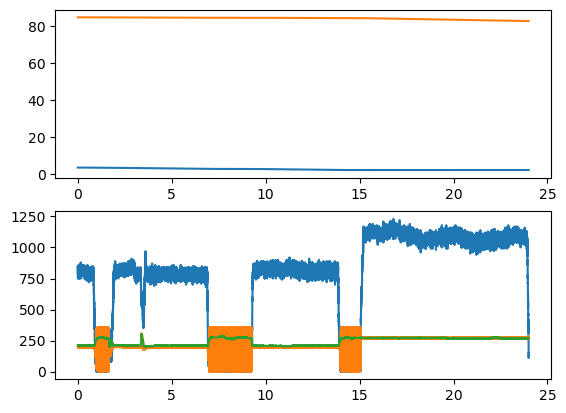

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x16ebcdb40>

In [7]:
dh = decimal_hour.(Dday[:time])

pltit(D,k) = plot(D[:time], D[k])

subplot(2,1,1)
plot(dh, Dday[:Lat_POSMV]) 
plot(dh, Dday[:Lon_POSMV])
subplot(2,1,2)
ushp,vshp = uvship.(Dday[:SOG_POSMV], Dday[:COG_POSMV])
plot(dh, 1e2*Dday[:SOG_POSMV], label="SOG")
plot(dh, Dday[:COG_POSMV], label="COG")
plot(dh, Dday[:Hed_gyro1], label="heading")

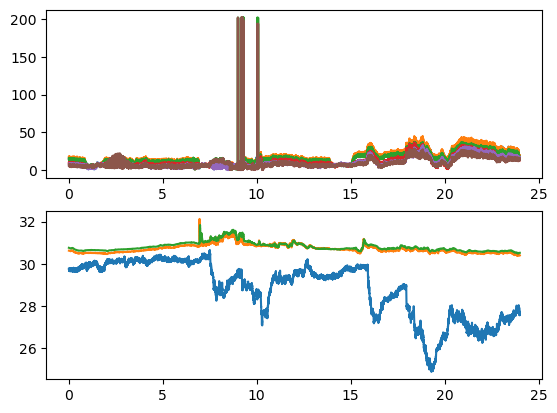

In [8]:
clf()
subplot(2,1,1)
for k in filter(s -> startswith(String(s), "RWS"), keys(Dday))
    plot(dh, Dday[k], label=String(k))
end
for k in filter(s -> startswith(String(s), "TWS"), keys(Dday))
    plot(dh, Dday[k], label=String(k))
end

subplot(2,1,2)
for k in [:Tair_met, :Tintake_SBE38, :Temp_TSG]
    plot(dh, Dday[k], label=String(k))
end

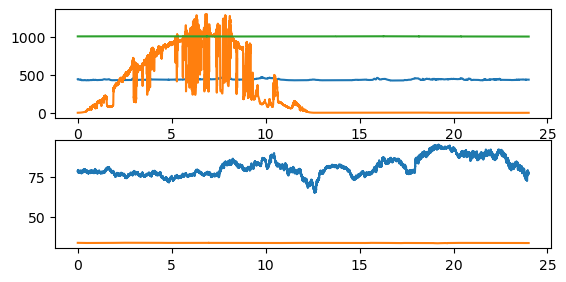

In [9]:
clf()
subplot(3,1,1)
for k in [:LW_SGR4, :SW_SMP10, :Bar_met] # :PAR, 
    plot(dh, Dday[k], label=String(k))
end
subplot(3,1,2)
for k in [:Hum_met, :Sal_TSG]
    plot(dh, Dday[k], label=String(k))
end
